# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

# Часть 1. SQL

Дана упрощенная схема базы данных:

![](https://drive.google.com/uc?export=view&id=1eZVg0OMLNh3Zn4Ss00oNw6KtcMYMTtdZ)

**telemetry** - таблица с телеметрией карьерных самосвалов следующего формата:

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 | 21:00:54 | 35 | 85,694 | 51.384 | 41.857 | 15.81 |

где
* id - номер записи в таблице
* objectid - идентификатор самосвала
* time - момент времени
* sensorid - идентификатор датчика
* value - значение, которое передал датчик
* lat, lon - координаты
* speed - текущая скорость самосвала

**objects** - таблица, в которой хранится информация о самосвалах:

| id | modelname | enterprise_id | created_at |
| :-: |:-: |:-: |:-: |
| 123 | БелАЗ-75131 | 4 | 01.01.2024 | 00:00:00 |

где
* id - идентификатор самосвала
* modelname - модель самосвала
* enterprise_id - идентификатор предприятия
* created_at - временная метка создания записи

**sensors** - таблица с описанием датчиков:

| id | name | tag | min_value | max_value |
| :-: |:-: |:-: |:-: | :-: |
| 35 | Вес | weight | 0 | 180 |

где
* id - идентификатор датчика
* name - наименование датчика
* tag - тег датчика
* min_value - минимальное допустимое значение датчика
* max_value - максимальное допустимое значение датчика


## Задание 1
Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75320” на предприятии с id = 6 выведет процент количества записей телеметрии, когда значение тега высоты (height) находилось в допустимых пределах, относительно всех записей по данному датчику за последние сутки.

### Примечание

По всей видимости, таблица **telemetry** составлена некорректно. Пропущено значение атрибута **value**. Атрибут **sensorid** содержит некорректное значение. Знаечние атрибута **sensorid**, видимо, содержится в атрибуте **value**. Корректный пример табилцы **telemetry** представлен ниже. В качестве примера значения атрибута **value** использована максимальная паспортная масса с грузом БЕЛАЗ-75131 в тоннах.

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 21:00:54 | 35 | 237,1 | 85,694 | 51.384 | 41.857 | 15.81 |

In [ ]:
SELECT t.objectid, o.modelname, o.enterprise_id, t.sensorid, 
    round(((count(*) FILTER (WHERE t.value BETWEEN s.min_value AND s.max_value))::numeric / count(*)::numeric)*100, 2) AS correct_val_pers
FROM telemetry AS t 
    JOIN objects AS o ON t.objectid = o.id
    JOIN sensors AS s ON t.sensorid = s.id
WHERE o.modelname = 'БелАЗ-75320' AND o.enterprise_id = 6 AND s.tag = 'height' AND current_timestamp - t.time < interval '24 hours'
-- Условие по времени написано из предположения, что поле time содержит значения в формате timestamp with time zone
GROUP BY t.objectid, o.modelname, o.enterprise_id, t.sensorid

## Задание 2
Необходимо написать запрос, для вывода уникальных значений по датчику satenum (количество доступных спутников связи) для каждого самосвала с идентификатором из списка [34, 42, 99] за последние двое суток.

In [ ]:
SELECT DISTINCT t.objectid, t.sensorid, t.value
FROM telemetry AS t 
    JOIN sensors AS s ON t.sensorid = s.id
WHERE t.objectid IN [34, 42, 99] AND s.name = 'satenum' AND current_timestamp - t.time < interval '48 hours'
-- Условие по времени написано из предположения, что поле time содержит значения в формате timestamp with time zone

## Задание 3
В таблицу с телеметрией собираются данные с датчика уровня топлива в процентах (тег fuel_tank_level). В данной задаче будем считать, что самосвалы в течение последнего часа ездят непрерывно, а значит и уровень топлива постепенно снижается. Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75131” вернет 1, если был зафиксирован хоть один случай, когда между двумя последовательными временными точками изменение уровня топлива было более 5%, или вывести 0, если подобной аномалии не было.

In [ ]:
-- Подзапрос составлен изходя из предположения, что один самосвал может обладать дублирующими датчиками
WITH fuel_lag_table AS (
    SELECT t.objectid, t.value - lag(t.value, 1, t.value) OVER (PARTITION BY t.objectid, t.sensorid ORDER BY t.time DESC) AS fuel_lag
    FROM telemetry AS t 
        JOIN objects AS o ON t.objectid = o.id
        JOIN sensors AS s ON t.sensorid = s.id
    WHERE o.modelname = 'БелАЗ-75131' AND s.tag = 'fuel_tank_level' AND current_timestamp - t.time < interval '1 hours'
)

SELECT ob.id, ob.modelname, 
    CASE WHEN EXISTS(SELECT 1 FROM fuel_lag_table AS flt WHERE ob.id = flt.objectid AND flt.fuel_lag > 5) THEN 1
        ELSE 0 
    END AS detected
FROM objects AS ob
WHERE ob.modelname = 'БелАЗ-75131'

# Часть 2. Python

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Предварительное преобразование данных

In [ ]:
# Для личного удобства принято решение предварительно преобразовать данные в объект pandas.DataFrame

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[8]").appName('PySpark').getOrCreate()

telemetry = spark.read.parquet('telemetry.parquet').toPandas()
weather = spark.read.parquet('weather_hourly.parquet').toPandas()

In [2]:
telemetry.head()

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 01:31:31.309,63.328824,83.727988,3.00394,195.7,390.00,NaN,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
1,1125,2023-11-07 23:21:39.000,63.334962,83.751046,0.00000,280.0,0.00,0.000,8.00,0,0,NaN,NaN,1003657.0,216.0,2887.0,0,637716.857273,7.025866e+06
2,1124,2023-11-08 15:20:55.000,63.343592,83.739678,4.20000,228.0,66.85,778.000,5.00,0,0,NaN,NaN,1003798.0,217.0,2875.0,0,637106.943106,7.026803e+06
3,1124,2023-11-08 10:16:39.000,63.343290,83.751773,16.80000,278.0,2.45,743.375,6.00,0,0,NaN,NaN,1003749.0,209.0,2875.0,0,637713.403209,7.026795e+06
4,1121,2023-11-08 07:09:49.347,63.331924,83.765388,0.00000,70.9,17.00,NaN,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06


In [3]:
weather.head()

,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,2023-11-07 23:00:00,0.0,0.0,-13.27,-20.02,-17.59,67.0,1027.0,3.48,8.91,60.0,100.0,10000.0,clouds,0,0,1
1,2023-11-08 09:00:00,0.0,0.0,-9.27,-15.79,-16.07,54.0,1020.0,4.13,8.20,71.0,100.0,10000.0,clouds,0,0,1
2,2023-11-07 21:00:00,0.0,0.0,-13.27,-20.10,-17.59,67.0,1028.0,3.55,8.92,62.0,95.0,10000.0,clouds,0,0,1
3,2023-11-07 19:00:00,0.0,0.0,-13.27,-19.67,-17.44,68.0,1030.0,3.18,7.71,61.0,94.0,10000.0,clouds,0,0,1
4,2023-11-07 14:00:00,0.0,0.0,-10.27,-16.63,-14.37,69.0,1033.0,3.72,9.60,64.0,65.0,10000.0,clouds,0,0,1


## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

In [4]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 

In [5]:
telemetry: pd.DataFrame
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426322 entries, 0 to 426321
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   objectid              426322 non-null  int64         
 1   time                  426322 non-null  datetime64[ns]
 2   lat                   426322 non-null  float64       
 3   lon                   426322 non-null  float64       
 4   speed                 426322 non-null  float64       
 5   height                426322 non-null  float64       
 6   fuel_cons             426322 non-null  float64       
 7   engine_speed          259203 non-null  float64       
 8   hdop                  426322 non-null  float64       
 9   DQ_vertical_bump      426322 non-null  int64         
 10  accelerator_position  426322 non-null  int64         
 11  fuel_tank_level       167118 non-null  float64       
 12  weight_dynamic        167119 non-null  float64       
 13 

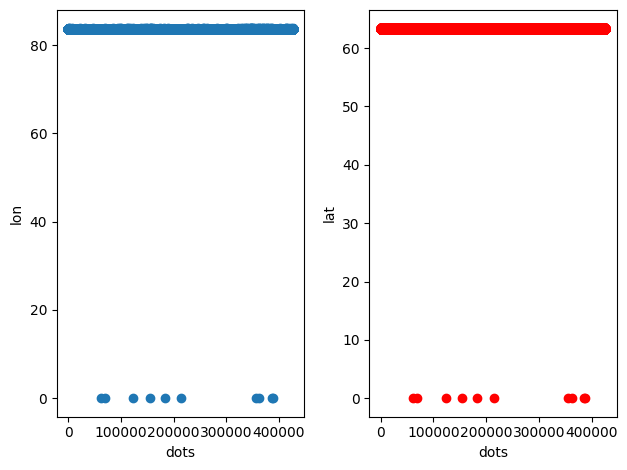

In [6]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(range(len(telemetry["lon"])), telemetry["lon"])
axs[0].set_ylabel('lon')
axs[0].set_xlabel('dots')

axs[1].scatter(range(len(telemetry["lat"])), telemetry["lat"], c='r')
axs[1].set_ylabel('lat')
axs[1].set_xlabel('dots')

plt.tight_layout()
plt.show()

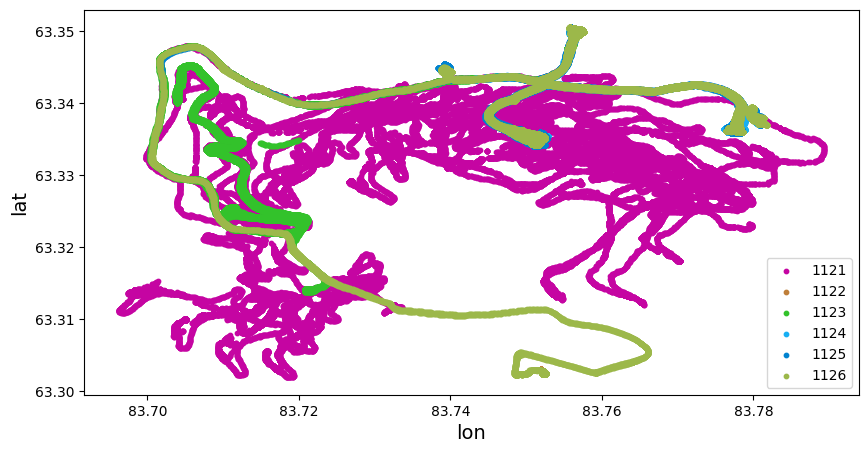

In [7]:
def rand_colors(num):
    randomizer = np.random.RandomState(10)
    colors = []
    for _ in range(num):
        rgb = randomizer.random_sample(3)
        colors.append(tuple(rgb))

    return colors

colors = rand_colors(len(np.unique(telemetry['objectid'])))

# Для построения маршрутов грузовиков без очевидных выбросов ограничим снизу lon и lat значениями 80 и 60 соответственно

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()
for objectid, color in zip(np.unique(telemetry['objectid']), colors):
    ax.scatter(
        telemetry["lon"].loc[(telemetry["lon"] > 80) & (telemetry['objectid'] == objectid)],
        telemetry["lat"].loc[(telemetry["lat"] > 60) & (telemetry['objectid'] == objectid)],
        s=10,
        color = color,
        label = objectid
    )
plt.xlabel('lon', size=14)
plt.ylabel('lat', size=14)
plt.legend()
plt.show()

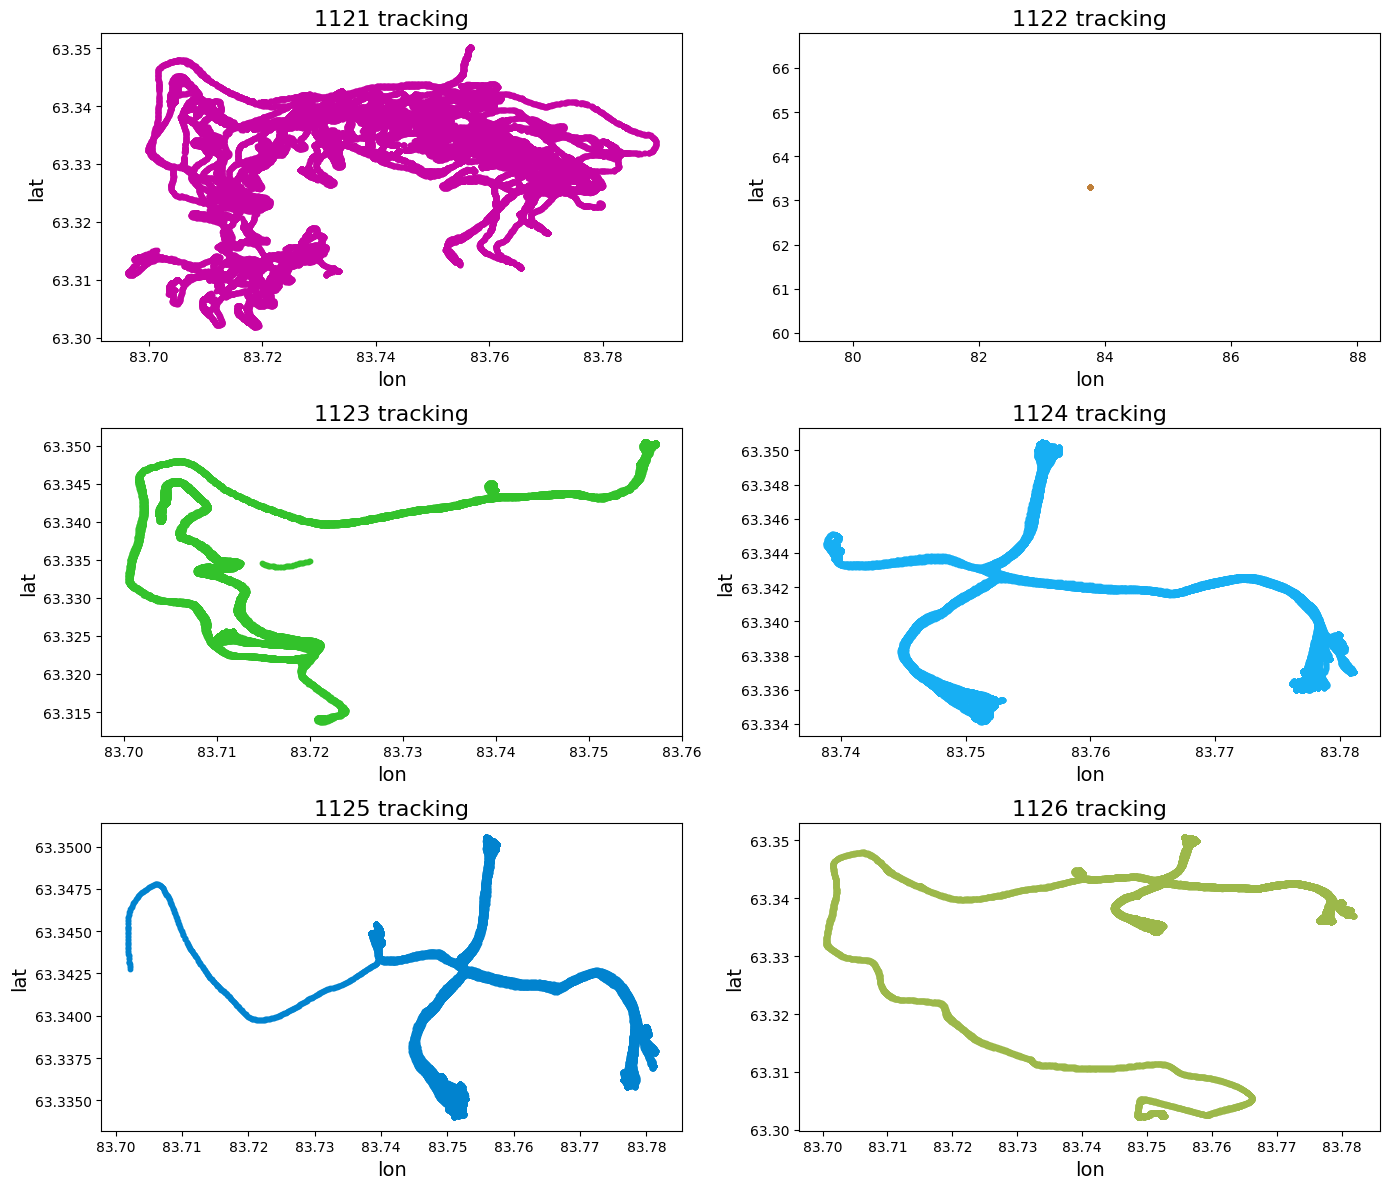

In [8]:
plt.figure(figsize=(14, 12))
for i, (objectid, color) in enumerate(zip(np.unique(telemetry['objectid']), colors)):
    ax = plt.subplot(3, 2, i+1)
    ax.scatter(
        telemetry["lon"].loc[(telemetry["lon"] > 80) & (telemetry['objectid'] == objectid)],
        telemetry["lat"].loc[(telemetry["lat"] > 60) & (telemetry['objectid'] == objectid)],
        s=10,
        color = color,
        label = objectid
    )
    ax.set_xlabel('lon', size=14)
    ax.set_ylabel('lat', size=14)
    ax.set_title(str(objectid) + ' tracking', size = 16)
plt.tight_layout()
plt.show()

In [9]:
telemetry[telemetry['objectid'] == 1122]

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
1073,1122,2023-11-08 16:59:39.486,63.303024,83.751988,0.001852,236.9,28.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
1226,1122,2023-11-08 17:02:02.486,63.303024,83.751988,0.001852,236.9,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
1470,1122,2023-11-08 17:02:33.471,63.303024,83.751988,0.001852,236.9,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
1606,1122,2023-11-08 17:03:12.483,63.303024,83.751988,0.001852,236.9,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
4443,1122,2023-11-08 16:58:39.492,63.303024,83.751988,0.135196,237.0,35.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421955,1122,2023-11-08 17:03:00.471,63.303024,83.751988,0.001852,236.9,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
422266,1122,2023-11-08 16:58:12.496,63.303024,83.751988,0.000000,237.0,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
422442,1122,2023-11-08 17:02:22.488,63.303024,83.751988,0.001852,236.9,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06
422651,1122,2023-11-08 17:01:56.499,63.303024,83.751988,0.001852,236.9,0.0,NaN,99.99,0,0,26.0,0.0,NaN,NaN,NaN,0,637916.72842,7.022312e+06


In [10]:
from sklearn.cluster import DBSCAN

lon = telemetry["lon"].loc[(telemetry["lon"] > 80) & (telemetry['objectid'] == 1123)].to_numpy()
lat = telemetry["lat"].loc[(telemetry["lat"] > 60) & (telemetry['objectid'] == 1123)].to_numpy()
X = np.hstack((lon.reshape(-1, 1), lat.reshape(-1, 1)))

dbscan = DBSCAN(eps=0.001, n_jobs=-1)
labels = dbscan.fit_predict(X)

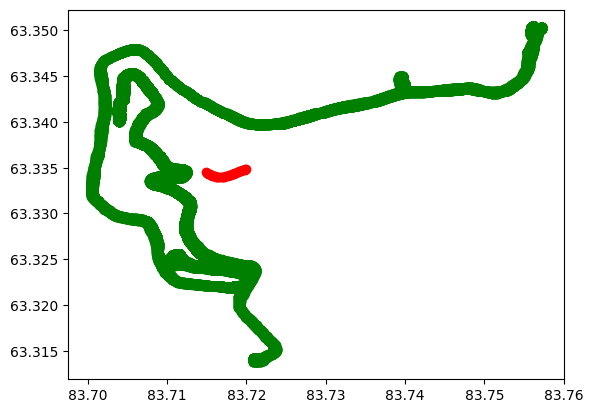

In [11]:
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], c = 'g')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c = 'r')
plt.show()

Рассмотрение треков самосвалов по отдельности позволило установить, что из датасета следует убрат записи о самосвале 1122 в связи с некорректностью данных. Эти записи выглядят как дубликаты (либо он все время стоял на месте, а значения сигналов с датчиков идеально повторялись, что маловероятно). 

Визуально различимых выбросов на геолокациях самосвалов обнаружить не получается. Все траектории выглядят правлоподобно и образут непрерывные маршруты. Единственная группа точек, которые можно интерпретировать как выбросы, прослеживается на геопозициях самосвала 1123 (отдельно отстоящий кусок траектории), хотя и его можно интерпретировать. Тем не менее, этот участок хорошо определеяется с помощью алгоритма кластеризации на основе плотности распределения (в данном случае использован DBSCAN).

Для формальной првоерки отсутствия значимых выбросов следует построить карту карьера после отбора значений геопозиции по интерквартильному размаху

In [12]:
drop_idx = telemetry[telemetry["objectid"] == 1123].index[labels == 1]
telemetry_ver2 = telemetry[
    (telemetry["objectid"] != 1122) & (telemetry["lon"] > 80) & (telemetry["lat"] > 60)
].drop(index=drop_idx)

In [13]:
from scipy.stats import iqr

lon_lat = telemetry_ver2[["lon", "lat"]]
lon_lat_q1 = lon_lat.quantile(q=0.25)
lon_lat_q3 = lon_lat.quantile(q=0.75)
lon_lat_iqr = lon_lat.apply(iqr)

geo = telemetry_ver2[["objectid", "lon", "lat"]][
    ~(
        (lon_lat < (lon_lat_q1 - 1.5 * lon_lat_iqr))
        | (lon_lat > (lon_lat_q3 + 1.5 * lon_lat_iqr))
    ).any(axis=1)
]

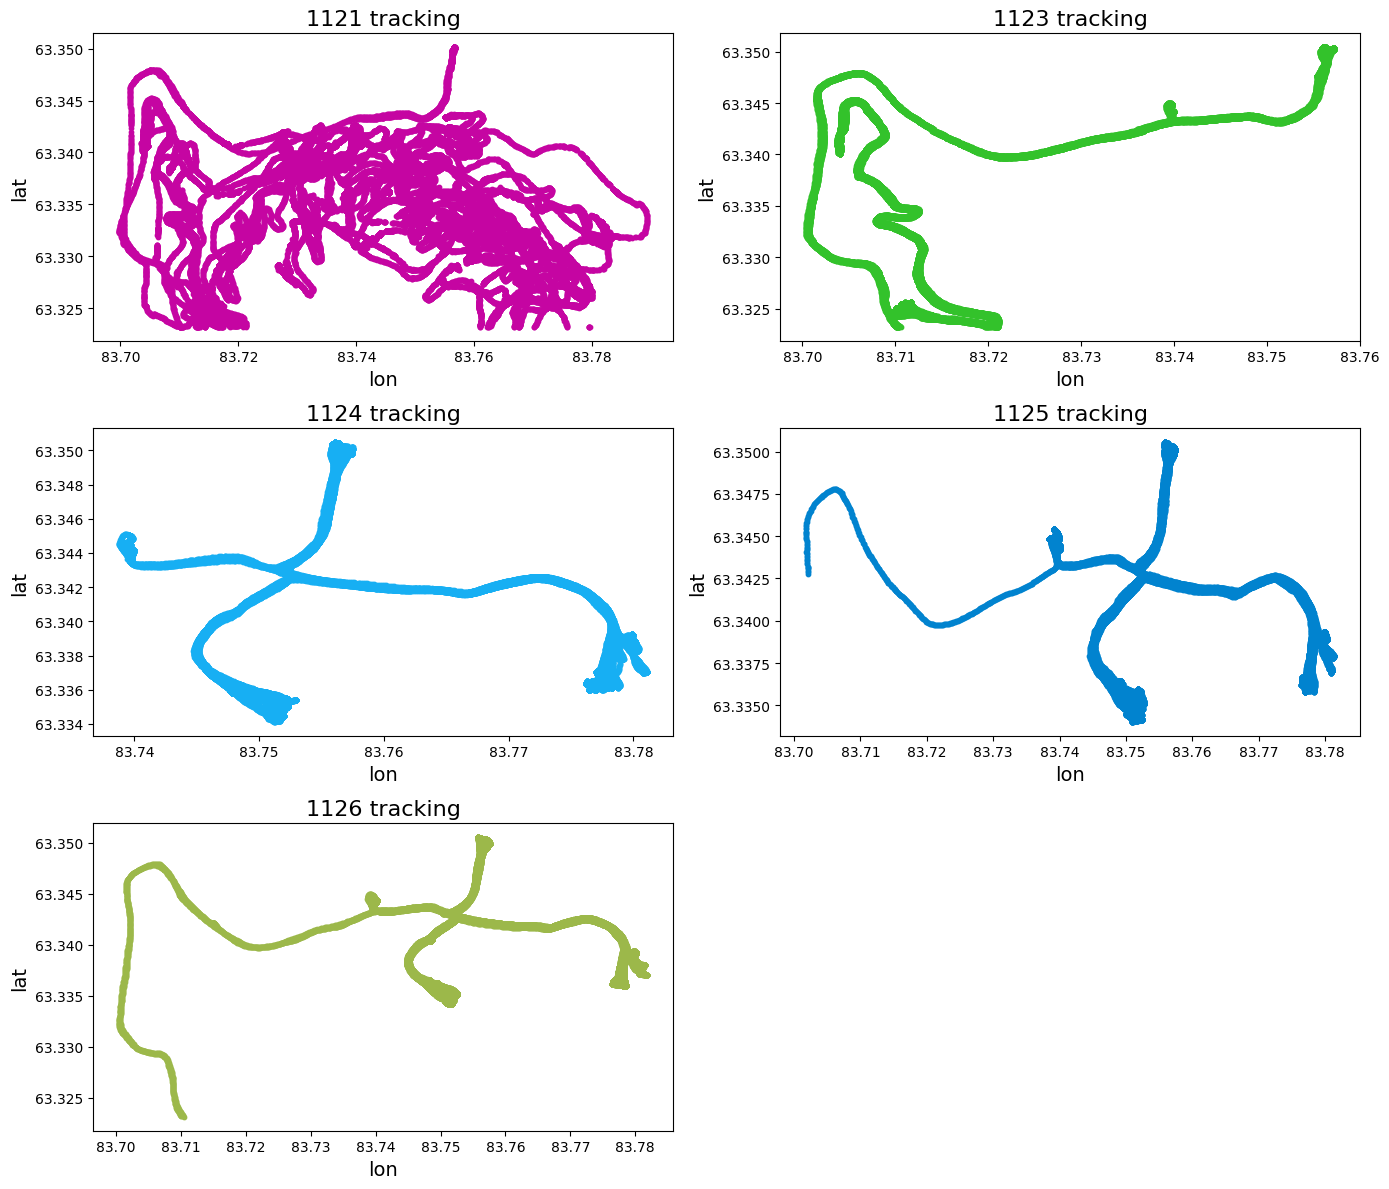

In [14]:
colors = [colors[0]] + colors[2:]
plt.figure(figsize=(14, 12))
for i, (objectid, color) in enumerate(zip(np.unique(geo['objectid']), colors)):
    ax = plt.subplot(3, 2, i+1)
    ax.scatter(
        geo["lon"][geo['objectid'] == objectid],
        geo["lat"][geo['objectid'] == objectid],
        s=10,
        color = color,
        label = objectid
    )
    ax.set_xlabel('lon', size=14)
    ax.set_ylabel('lat', size=14)
    ax.set_title(str(objectid) + ' tracking', size = 16)
plt.tight_layout()
plt.show()

После удаления выбросов с помощью IQR траектории некоторых самосвалов оказалиь срезанными. Таким образом, по всей видимости, выбросов в измерениях геопозиции нет. Онончательный вариант карты карьера представлен ниже.

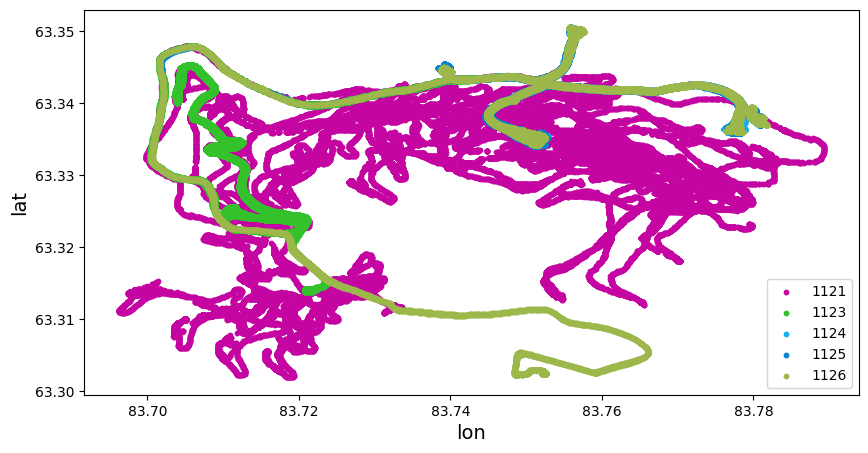

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()
for objectid, color in zip(np.unique(telemetry_ver2['objectid']), colors):
    ax.scatter(
        telemetry_ver2["lon"][telemetry_ver2['objectid'] == objectid],
        telemetry_ver2["lat"][telemetry_ver2['objectid'] == objectid],
        s=10,
        color = color,
        label = objectid
    )
plt.xlabel('lon', size=14)
plt.ylabel('lat', size=14)
plt.legend()
plt.show()

In [16]:
telemetry_ver2['accelerator_position'].isin([0]).sum(), telemetry_ver2['DQ_vertical_bump'].isin([0]).sum(), telemetry_ver2.shape[0]

(425920, 425920, 425920)

In [17]:
# Перед рассмотрение остальных колонок заполним пропуски в fuel_tank_level и weight_dynamic. 
# Колонки accelerator_position и DQ_vertical_bump полностью нулевые и не несут значимой информации. Их можно удалить.
# Колонка engine_spped имеет много пропущенных значений. Для сохранения объема выборки пропущенные значения будут заполнены средним по выборке.
# Оставшиеся строки с пропущенными значениями также будут удалены

telemetry_ver2.drop(['accelerator_position', 'DQ_vertical_bump'], axis=1, inplace=True)
es_mean = telemetry_ver2['engine_speed'].mean()
telemetry_ver2['engine_speed'].fillna(es_mean, inplace=True)

telemetry_ver2 = telemetry_ver2.sort_values(by='time', ascending=False)

for name in ['fuel_tank_level', 'weight_dynamic']:
    
    dummy = telemetry_ver2[name].replace(np.nan, None).to_list()[::-1]
    # первое ненулевое значение 
    for val in dummy:
        if not val:
            continue
        else:
            curr_val = val
            break

    for i, val in enumerate(dummy):
        if not val:
            dummy[i] = curr_val
        else:
            curr_val = val
    telemetry_ver2[name] = dummy[::-1]

telemetry_ver2.dropna(inplace=True)

In [18]:
telemetry_clear = telemetry_ver2
telemetry_clear

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
375655,1126,2023-11-08 20:00:00.000,63.342207,83.756331,37.90000,273.0,16.25,701.000000,6.00,31.0,207.0,1003840.0,224.0,2909.0,1,637946.593240,7.026684e+06
227749,1121,2023-11-08 19:59:59.827,63.310824,83.731288,2.34093,-405.5,393.00,1099.331509,99.99,31.0,207.0,1003839.0,207.0,2894.0,1,636842.794877,7.023136e+06
218362,1126,2023-11-08 19:59:59.000,63.342207,83.756331,37.90000,273.0,16.70,703.000000,6.00,31.0,207.0,1003840.0,224.0,2909.0,1,637946.593240,7.026684e+06
410224,1121,2023-11-08 19:59:58.827,63.310824,83.731288,2.02238,-405.6,385.00,1099.331509,99.99,31.0,207.0,1003839.0,207.0,2894.0,1,636842.794877,7.023136e+06
246912,1126,2023-11-08 19:59:58.000,63.342224,83.755998,38.30000,273.0,21.20,699.000000,6.00,31.0,207.0,1003840.0,224.0,2909.0,1,637929.853778,7.026685e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420794,1121,2023-11-07 20:00:00.803,63.346624,83.702188,19.45900,132.0,390.00,1099.331509,4.91,41.0,209.0,1003626.0,210.0,2891.0,1,635217.355791,7.027060e+06
69525,1123,2023-11-07 20:00:00.231,63.322524,83.711388,36.71030,122.6,140.00,1099.331509,1.46,64.0,209.0,1003629.0,211.0,2902.0,0,635791.086337,7.024396e+06
187383,1126,2023-11-07 20:00:00.000,63.335462,83.752151,0.10000,277.0,35.85,1100.000000,8.00,64.0,209.0,1003628.0,209.0,2907.0,1,637769.756331,7.025924e+06
56789,1125,2023-11-07 20:00:00.000,63.342790,83.702106,32.40000,91.0,0.00,0.000000,8.00,64.0,209.0,1003632.0,219.0,2887.0,0,635231.261311,7.026633e+06


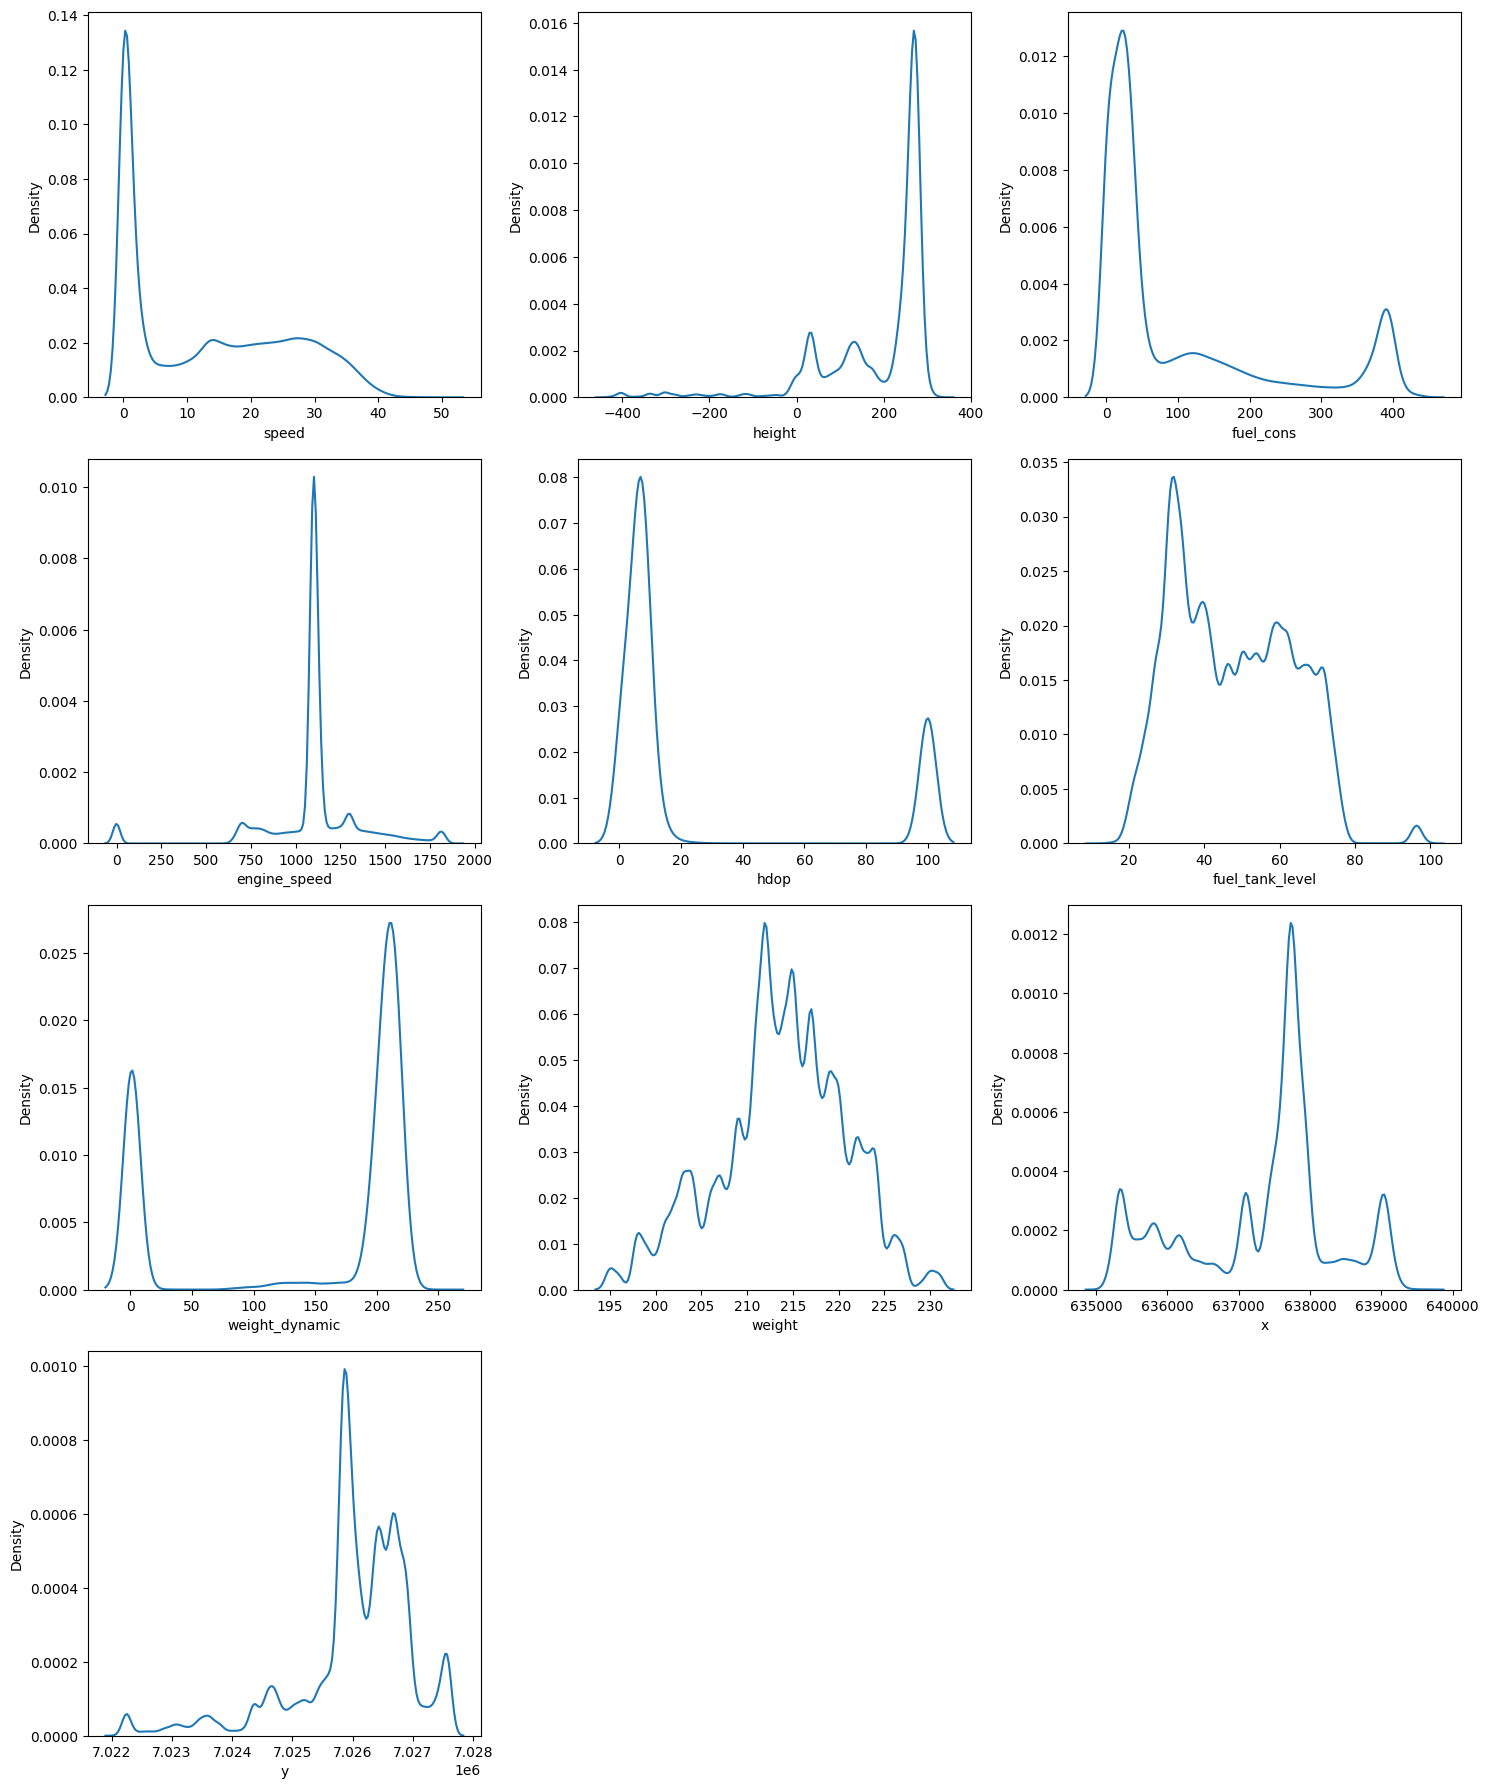

In [19]:
names = [
    "speed",
    "height",
    "fuel_cons",
    "engine_speed",
    "hdop",
    "fuel_tank_level",
    "weight_dynamic",
    "weight",
    "x",
    "y",
]
plt.figure(figsize=(15, 18))
for i, name in enumerate(names):
    ax = plt.subplot(4, 3, i + 1)
    ax = sns.kdeplot(data=telemetry_clear, x=name)
plt.tight_layout()
plt.show()

Плотности распределения данных свидительствуют об отсутствии значений, которые следует считать выбросами. Подозрения вызывает график плотности распределения дял height. Однако, будем считать, что начало отсчета датчика не привязано к уровню моря

[]

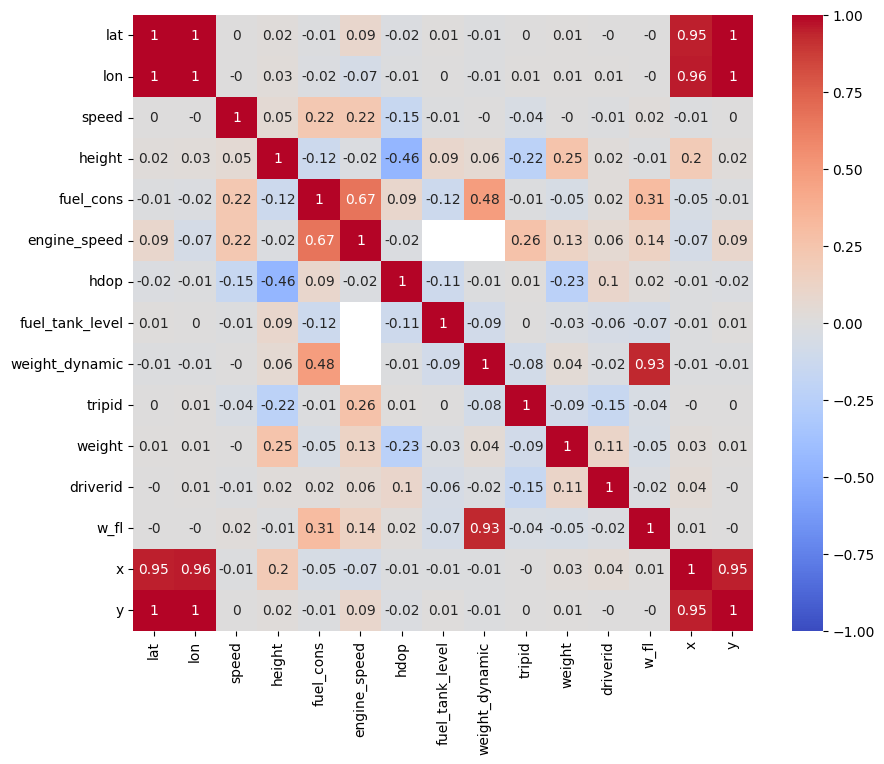

In [20]:
telemetry = telemetry.sort_values(by="time", ascending=False)
telemetry.drop(["accelerator_position", "DQ_vertical_bump"], axis=1, inplace=True)
corr = telemetry.iloc[:, 2:].corr(method="pearson").round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.plot()

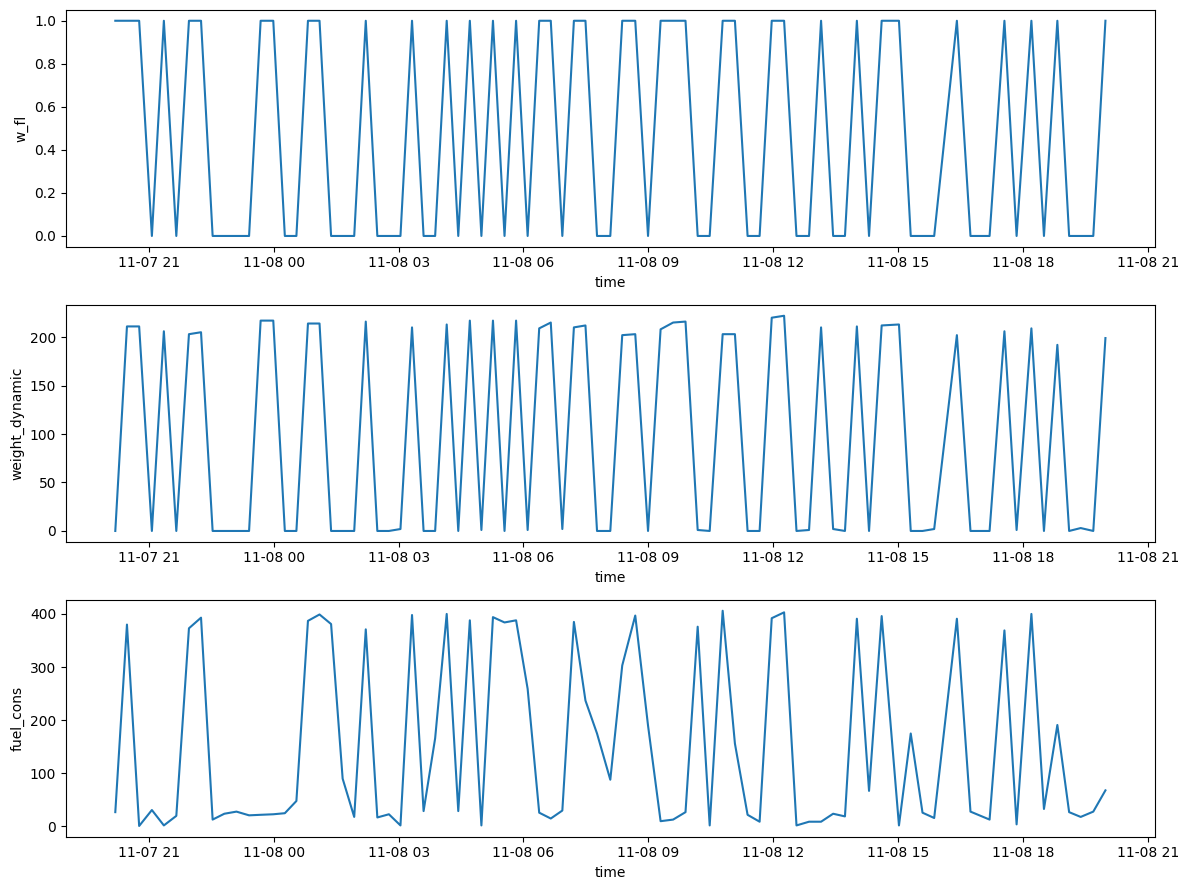

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 9))
sns.lineplot(
    data=telemetry[telemetry["objectid"] == 1123][::1000], 
    x="time", 
    y="w_fl", 
    ax=ax1
)
sns.lineplot(
    data=telemetry[telemetry["objectid"] == 1123][::1000],
    x="time",
    y="weight_dynamic",
    ax=ax2,
)
sns.lineplot(
    data=telemetry[telemetry["objectid"] == 1123][::1000],
    x="time",
    y="fuel_cons",
    ax=ax3,
)
plt.tight_layout()
plt.show()

Исходя из значений атрибута **w_ll**, матрицы корреляции и временных зависимостей, можно предположить, что **w_ll** является индикатором, свидительствующим о том, загружен ли самосвал или пуст в данный момент времени

## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

In [22]:
# DQ_vertical_bump в расчетах не учавствует

atribs = ["hdop", "speed", "engine_speed", "height"]
mean_df = telemetry_clear.groupby('objectid')[atribs].mean()
mean_df

,hdop,speed,engine_speed,height
objectid,,,,
1121,92.918064,9.921136,1099.331509,62.150815
1123,2.466132,16.335559,1099.331509,90.755490
1124,7.037529,12.791666,1135.849790,266.987452
1125,8.445042,13.657709,999.896761,264.803802
1126,7.584820,13.430823,1161.572864,262.754274


In [23]:
def calc_dist(x_difs, y_difs):
    dist = 0
    for x_dif, y_dif in zip(x_difs, y_difs):
        dist += (x_dif**2 + y_dif**2)**0.5
    return round(dist)

lst_dist = []
for df in telemetry_clear.groupby(['objectid', 'tripid'])[['x', 'y']]:
    x_difs = df[1].diff()['x'][1:]
    y_difs = df[1].diff()['y'][1:]
    lst_dist.append(calc_dist(x_difs, y_difs))
        

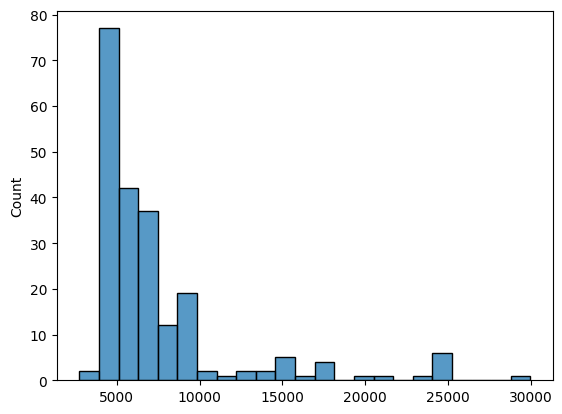

In [24]:
sns.histplot(data=lst_dist)
plt.show()

In [25]:
mean_speed_df = telemetry_clear.groupby(['objectid', telemetry_clear['time'].dt.hour])['speed'].mean()
mean_speed_df.unstack(level=-1)

time,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
objectid,,,,,,,,,,,,,,,,,,,,,
1121,13.865112,5.952499,7.554358,4.958597,7.181664,11.518727,12.987635,8.120189,11.309570,13.037133,...,13.732471,9.268503,9.241412,11.137591,8.723652,5.201494,18.466040,12.862556,8.235196,6.410654
1123,21.848800,15.330034,9.890281,11.867700,16.240954,15.558113,18.634950,21.183641,20.765935,20.706454,...,17.851139,7.849254,12.966198,15.429917,13.583356,4.830119,22.358631,18.714639,21.400921,11.881461
1124,14.064222,12.226444,14.285306,5.915778,11.248639,12.159278,12.731500,2.610639,9.365639,13.808056,...,13.014444,7.291333,19.083028,20.814111,15.509917,17.031289,19.359444,15.550194,17.290861,10.585278
1125,17.857639,15.306083,13.476444,11.308389,13.151722,12.256889,11.728583,4.791389,10.079639,13.925667,...,13.657278,6.873750,16.893639,20.637611,17.667306,12.841739,13.207333,17.689444,17.936111,16.948139
1126,17.381333,15.643083,14.816139,6.677806,13.042917,12.466944,12.126750,3.777972,9.362583,17.200056,...,12.940250,8.752861,17.955361,20.612500,15.397639,15.169694,17.664315,18.087889,15.322750,12.422889


In [26]:
ids = [1121, 1123, 1124, 1125, 1126][::-1]
data = {}
for df in telemetry_clear.groupby(['objectid', 'tripid'])[['lon', 'lat', 'time', 'speed', 'height']]:
    if not ids:
        break
    if df[0][0] == ids[-1]:
        data[ids.pop()] = df[1]
        

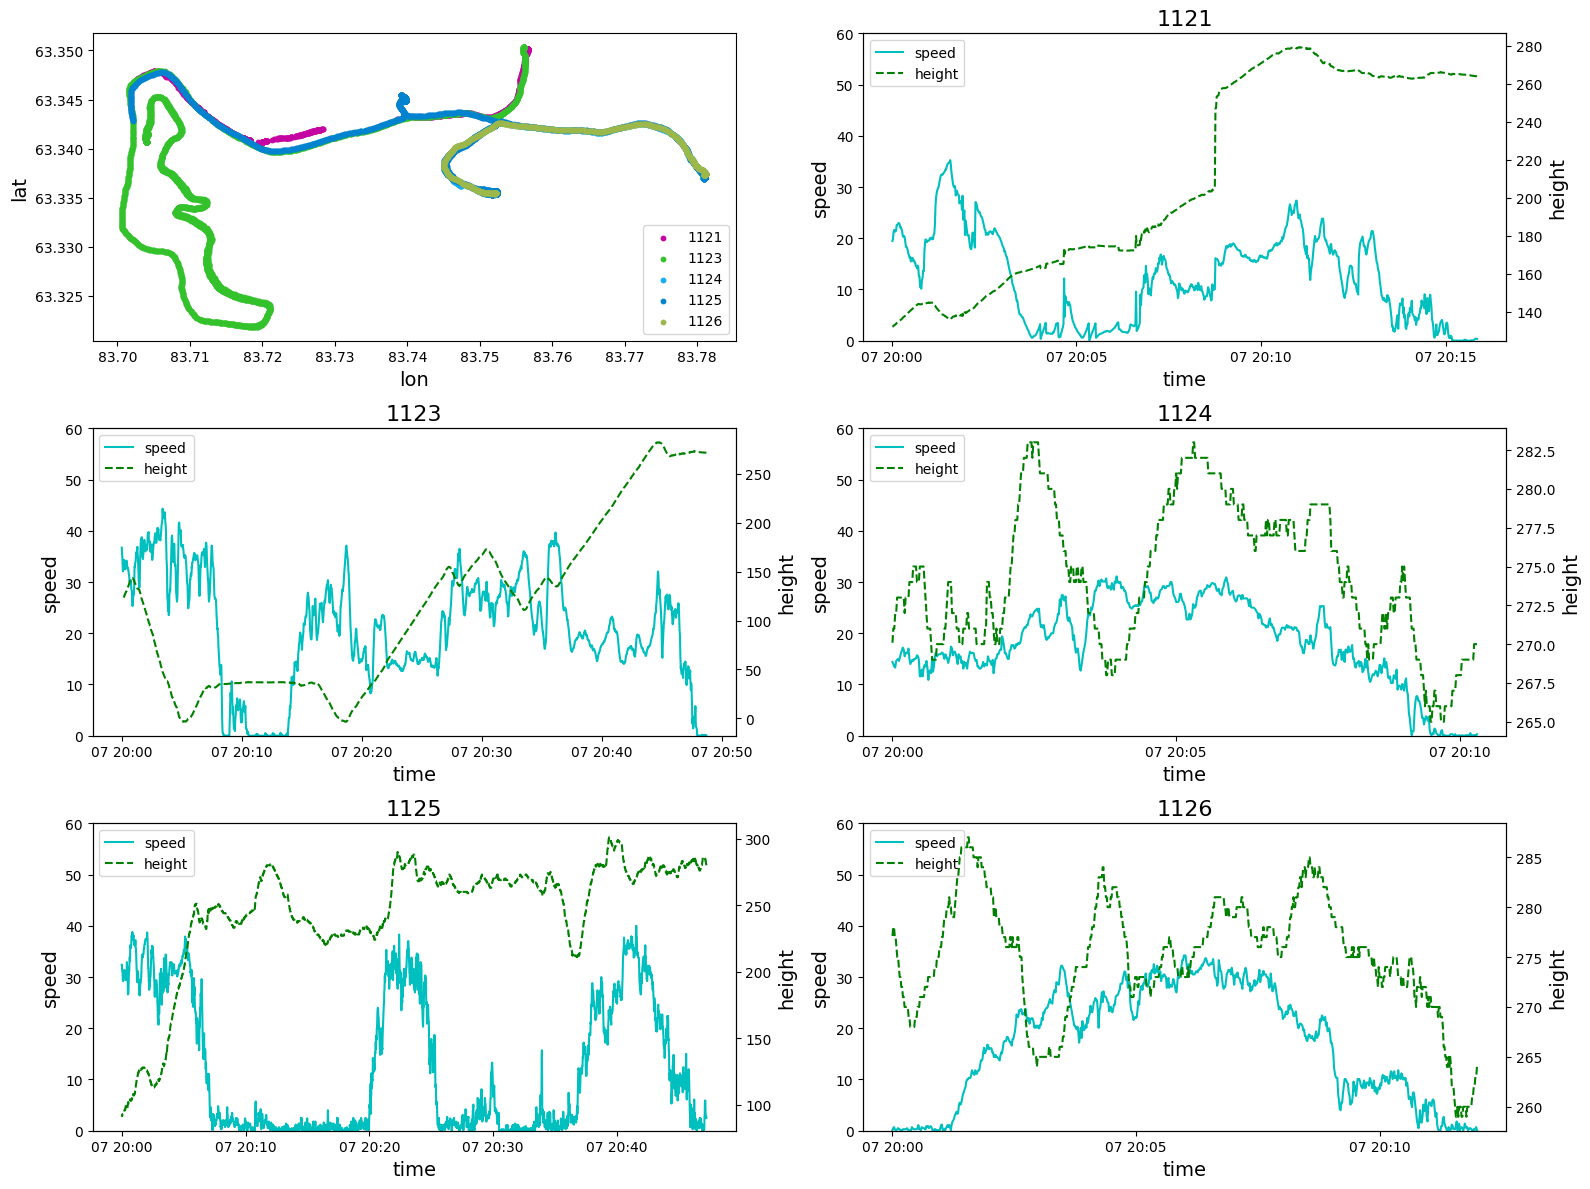

In [27]:
plt.figure(figsize=(16, 12))
ax1 = plt.subplot(3, 2, 1)
for i, (color, (id, df)) in enumerate(zip(colors, data.items()), start=2):
    ax1.scatter( df["lon"], df["lat"], s=10, color = color, label = id)
    ax2 = plt.subplot(3, 2, i)
    ax2.set_ylim([0, 60])
    ax3 = ax2.twinx()
    line1, = ax2.plot(df['time'], df['speed'], c='c', label='speed')
    line2, = ax3.plot(df['time'], df['height'], linestyle='--', c='g', label='height')
    
    ax2.set_xlabel('time', size=14)
    ax2.set_ylabel('speed', size=14)
    ax3.set_ylabel('height', size=14)
    ax2.legend(handles = [line1, line2], loc=2)
    ax2.set_title(id, size = 16)

ax1.set_xlabel('lon', size=14)
ax1.set_ylabel('lat', size=14)
ax1.legend()

plt.tight_layout()
plt.show()
    

In [28]:
weather.sort_values(by='time', inplace=True)
telemetry_clear.sort_values(by='time', inplace=True)

In [29]:
full_data = pd.merge_asof(telemetry_clear, weather, on='time', direction='backward')

In [30]:
full_data

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,fuel_tank_level,...,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,1124,2023-11-07 20:00:00.000,63.336150,83.747419,14.40000,270.0,2.60,994.250000,8.00,64.0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
1,1125,2023-11-07 20:00:00.000,63.342790,83.702106,32.40000,91.0,0.00,0.000000,8.00,64.0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
2,1126,2023-11-07 20:00:00.000,63.335462,83.752151,0.10000,277.0,35.85,1100.000000,8.00,64.0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
3,1123,2023-11-07 20:00:00.231,63.322524,83.711388,36.71030,122.6,140.00,1099.331509,1.46,64.0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
4,1121,2023-11-07 20:00:00.803,63.346624,83.702188,19.45900,132.0,390.00,1099.331509,4.91,41.0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425312,1126,2023-11-08 19:59:58.000,63.342224,83.755998,38.30000,273.0,21.20,699.000000,6.00,31.0,...,1018.0,1.73,5.51,94.0,100.0,9169.0,clouds,0,0,1
425313,1121,2023-11-08 19:59:58.827,63.310824,83.731288,2.02238,-405.6,385.00,1099.331509,99.99,31.0,...,1018.0,1.73,5.51,94.0,100.0,9169.0,clouds,0,0,1
425314,1126,2023-11-08 19:59:59.000,63.342207,83.756331,37.90000,273.0,16.70,703.000000,6.00,31.0,...,1018.0,1.73,5.51,94.0,100.0,9169.0,clouds,0,0,1
425315,1121,2023-11-08 19:59:59.827,63.310824,83.731288,2.34093,-405.5,393.00,1099.331509,99.99,31.0,...,1018.0,1.73,5.51,94.0,100.0,9169.0,clouds,0,0,1


## Задание 3

**Обучить модель для предсказания значений скорости самосвала (колонка speed)**
* Можно (и даже нужно) генерировать дополнительные фичи.
* Выполнить необходимые (на Ваш взгляд) преобразования датасета.
* Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики
* Обучить несколько моделей и сравнить их. Интерпретировать результаты.

В данном задании предлагается немного изменить подход к работе с пропущенными значениями

In [31]:
telemetry_new = telemetry[
    (telemetry["objectid"] != 1122) & (telemetry["lon"] > 80) & (telemetry["lat"] > 60)
].drop(index=drop_idx)

In [32]:
telemetry_new.sort_values(by='time', inplace=True)
dataset = pd.merge_asof(telemetry_new, weather, on='time', direction='backward')

In [33]:
fw_data = dataset[['time', 'fuel_tank_level', 'weight_dynamic']]
fw_clean = fw_data.dropna()
fw_data = pd.merge_asof(fw_data['time'], fw_clean, on='time')

In [34]:
dataset[['fuel_tank_level', 'weight_dynamic']] = fw_data[['fuel_tank_level', 'weight_dynamic']]
dataset.dropna(inplace=True)

In [35]:
dataset.shape

(258597, 33)

[]

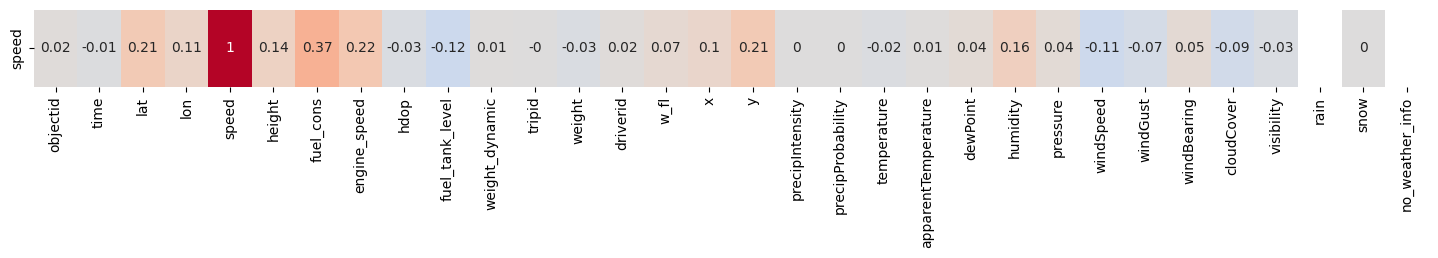

In [36]:
corr = dataset.loc[:, dataset.columns != 'precipType'].corr().round(2)
plt.figure(figsize=(18, 1))
sns.heatmap(data=corr.loc[corr.index == 'speed', :], cmap="coolwarm", annot=True, vmin=-1, vmax=1, square=False, cbar=False)
plt.plot()

In [37]:
dataset.columns

Index(['objectid', 'time', 'lat', 'lon', 'speed', 'height', 'fuel_cons',
       'engine_speed', 'hdop', 'fuel_tank_level', 'weight_dynamic', 'tripid',
       'weight', 'driverid', 'w_fl', 'x', 'y', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing',
       'cloudCover', 'visibility', 'precipType', 'rain', 'snow',
       'no_weather_info'],
      dtype='object')

- атрибуты **x**, **y**, **windSpeed**, **windGust**, **windBearing** будут перобразованы в координаты двумерного вектора **sum_vec_x**, **sum_vec_y** характерезующего взаимосвязь направления двежения самосала и направления, скорости и порывов ветра
- на основе атрибутов **temperature** и **dewPoint** будет сформирован индикативный атрибут **rosa** характерезующий наличие или отсутствие росы/тумана
- атрибуты **lon**, **lat**, **time**, **tripid**, **weight**, **w_fl**, **precipProbability**, **apparentTemperature**, **dewPoint**, **pressure**, **cloudCover**, **precipType**, **rain**, **snow**, **no_weather_info** будут удалены как предположительно неинформативные для скорости или дублирующие информацию 

In [38]:
dataset.sort_values(by='time', ascending=False, inplace=True)

In [39]:
dummy = pd.concat((dataset[['x', 'y']].diff(), dataset[['windSpeed', 'windGust', 'windBearing']]), axis=1)[1:]

In [40]:
x_w = dummy['windSpeed'].to_numpy() * np.cos(((90 - dummy['windBearing'].to_numpy()) / 180) * np.pi)
y_w = dummy['windSpeed'].to_numpy() * np.sin(((90 - dummy['windBearing'].to_numpy()) / 180) * np.pi)
sum_vec_x = dummy['windBearing'].to_numpy() * (dummy['x'].to_numpy() + x_w)
sum_vec_y = dummy['windBearing'].to_numpy() * (dummy['y'].to_numpy() + y_w)

sum_vec = pd.DataFrame({'sum_vec_x': sum_vec_x, 'sum_vec_y': sum_vec_y}) 

In [41]:
def check(T, dp):
    if T < dp:
        return 1
    else:
        return 0

rosa = dataset.apply(lambda x: check(x['temperature'], x['dewPoint']), axis=1)

За рассматриваемый промежуток времени атрибуты **rosa** и **precipIntensity** принимают нулевое значение для всей выборки. В иной ситуации эти признаки могли бы косвенно влиять на скорость движения транспортного средства. В данном случае, датасет эти признаки включены не буудт

In [42]:
atribs = [
    "objectid",
    "height",
    "fuel_cons",
    "engine_speed",
    "hdop",
    "fuel_tank_level",
    "weight_dynamic",
    "driverid",
    "temperature",
    "humidity",
    "visibility",
]

df = pd.concat(
    (
        dataset[atribs][1:].reset_index(drop=True),
        sum_vec.reset_index(drop=True),
        dataset["speed"][1:].reset_index(drop=True),
    ),
    axis=1,
)

In [43]:
df

,objectid,height,fuel_cons,engine_speed,hdop,fuel_tank_level,weight_dynamic,driverid,temperature,humidity,visibility,sum_vec_x,sum_vec_y,speed
0,1126,273.0,16.70,703.000,6.0,31.0,207.0,2909.0,-7.27,72.0,9169.0,162.223866,-11.343798,37.9
1,1126,273.0,21.20,699.000,6.0,31.0,207.0,2909.0,-7.27,72.0,9169.0,-1411.285618,99.216932,38.3
2,1126,273.0,22.90,683.000,6.0,31.0,207.0,2909.0,-7.27,72.0,9169.0,162.223866,-11.343798,38.3
3,1126,274.0,5.10,686.000,6.0,31.0,207.0,2909.0,-7.27,72.0,9169.0,-1445.550545,129.208647,39.4
4,1126,274.0,0.00,736.000,6.0,31.0,207.0,2909.0,-7.27,72.0,9169.0,162.223866,-11.343798,39.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258591,1126,278.0,35.80,1100.000,8.0,41.0,209.0,2907.0,-13.27,69.0,10000.0,149985.957943,-42863.897628,0.7
258592,1124,271.0,125.75,974.750,8.0,41.0,209.0,2884.0,-13.27,69.0,10000.0,-14259.800790,4323.831636,13.5
258593,1126,278.0,35.80,1100.000,12.0,41.0,209.0,2907.0,-13.27,69.0,10000.0,14604.507492,-4125.247894,0.5
258594,1124,271.0,4.65,900.125,8.0,41.0,209.0,2884.0,-13.27,69.0,10000.0,-14118.372685,4198.267548,14.0


[]

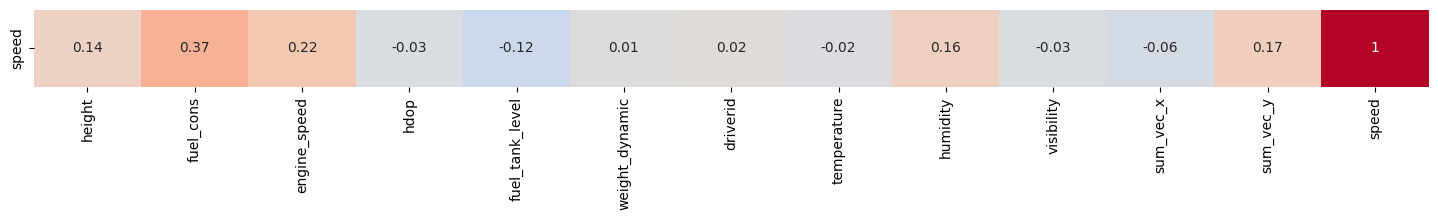

In [44]:
corr = df.iloc[:, 1:].corr().round(2)
plt.figure(figsize=(18, 1))
sns.heatmap(data=corr.loc[corr.index == 'speed', :], cmap="coolwarm", annot=True, vmin=-1, vmax=1, square=False, cbar=False)
plt.plot()

Для поставленной задачи регрессии будут использованы 2 алгоритма: линейная регрессия и градиентный бустинг.
В качетве метрик будут использованы R2 и MSE, как наиболее подходящие в задачах регрессии

In [99]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [67]:
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()

In [68]:
std = StandardScaler()
X_std = std.fit_transform(X)

In [69]:
def reduce_dim(X, sigm: float = 0.8):
    """
    Определяет оптимальное количество главных компонент для сохранения заданного порога объясненной дисперсии

    Args:
        X (array-like) of shape (n_samples, n_features): Исходный массив
        sigm (float): Порог объясненной дисперсии, default=0.8

    Returns:
        X_new (array-like) of shape (n_samples, n_components): Спроецированный массив
    """
    reducer = PCA(n_components=X.shape[1], random_state=42)
    reducer.fit(X)
    opt_n_pc = np.count_nonzero(np.cumsum(reducer.explained_variance_ratio_) < sigm)
    opt_reducer = PCA(opt_n_pc, random_state=42)
    return opt_reducer.fit_transform(X), opt_reducer

In [70]:
X_std_rd = reduce_dim(X_std, 0.95)[0]
X_std_rd.shape

(258596, 10)

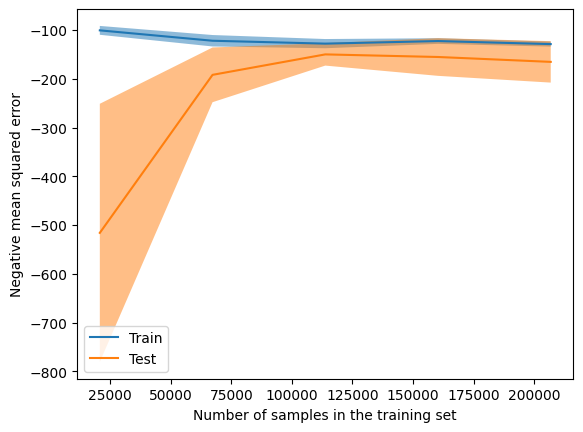

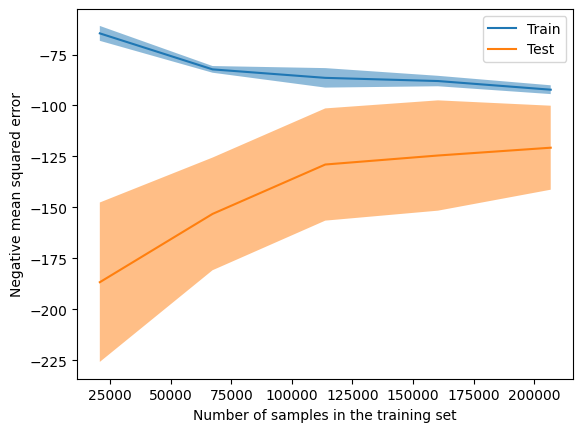

In [71]:
#Оценка размера выборки

lr = SGDRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
LearningCurveDisplay.from_estimator(lr, X_std_rd, Y, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
LearningCurveDisplay.from_estimator(gb, X_std_rd, Y, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
plt.show()

Обе кривые начинают выходить на плато примерно после размера выборки 125 000 образцов. Дальнейший подбор параметров моделй будет происходить на выборке размером 125 000 образцов

In [73]:
X = X[:125000, :]
Y = Y[:125000]

In [ ]:
# Разделим отобранный датасет на тренировочный и тестовый наборы и еще раз проведем предобработку

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

X_train_rd, reducer = reduce_dim(X_train_std, 0.95)
X_test_rd = reducer.transform(X_test_std)

In [86]:
lr_params = {'penalty': [None, 'l2'], 'alpha': [0.0001, 0.001, 0.01] ,'learning_rate': ['invscaling', 'optimal']}
gb_params = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
gs_lr = GridSearchCV(lr, param_grid=lr_params, scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1, cv=5, return_train_score=True, refit=False)
gs_gb = GridSearchCV(gb, param_grid=gb_params, scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1, cv=5, return_train_score=True, refit=False)

In [87]:
gs_lr.fit(X_train_rd, Y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'learning_rate': ['invscaling', 'optimal'],
                         'penalty': [None, 'l2']},
             refit=False, return_train_score=True,
             scoring=['neg_mean_squared_error', 'r2'])

In [94]:
pd.reset_option("display.max_columns")
gs_lr_df = pd.DataFrame(gs_lr.cv_results_)
attrs = [
    "params",
    "mean_train_neg_mean_squared_error",
    "mean_test_neg_mean_squared_error",
    "rank_test_neg_mean_squared_error",
    'mean_train_r2',
    "mean_test_r2",
    'rank_test_r2'
]
gs_lr_df[attrs].sort_values(by='rank_test_neg_mean_squared_error')

,params,mean_train_neg_mean_squared_error,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_r2,mean_test_r2,rank_test_r2
10,"{'alpha': 0.01, 'learning_rate': 'optimal', 'p...",-132.918111,-132.948165,1,0.228732,0.228541,1
11,"{'alpha': 0.01, 'learning_rate': 'optimal', 'p...",-132.920084,-132.949267,2,0.228720,0.228535,2
7,"{'alpha': 0.001, 'learning_rate': 'optimal', '...",-133.061764,-133.064961,3,0.227898,0.227865,3
6,"{'alpha': 0.001, 'learning_rate': 'optimal', '...",-133.061682,-133.064989,4,0.227898,0.227865,4
5,"{'alpha': 0.001, 'learning_rate': 'invscaling'...",-133.075674,-133.112598,5,0.227817,0.227589,5
1,"{'alpha': 0.0001, 'learning_rate': 'invscaling...",-133.075797,-133.112807,6,0.227816,0.227588,6
0,"{'alpha': 0.0001, 'learning_rate': 'invscaling...",-133.075815,-133.112835,7,0.227816,0.227588,7
4,"{'alpha': 0.001, 'learning_rate': 'invscaling'...",-133.075815,-133.112835,7,0.227816,0.227588,7
8,"{'alpha': 0.01, 'learning_rate': 'invscaling',...",-133.075815,-133.112835,7,0.227816,0.227588,7
9,"{'alpha': 0.01, 'learning_rate': 'invscaling',...",-133.077801,-133.113899,10,0.227805,0.227582,10


In [88]:
gs_gb.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             refit=False, return_train_score=True,
             scoring=['neg_mean_squared_error', 'r2'])

In [96]:
gs_gb_df = pd.DataFrame(gs_gb.cv_results_)
gs_gb_df[attrs].sort_values(by='rank_test_neg_mean_squared_error')

,params,mean_train_neg_mean_squared_error,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_r2,mean_test_r2,rank_test_r2
11,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",-37.531516,-53.880328,1,0.782220,0.687332,1
10,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",-47.404189,-57.980975,2,0.724932,0.663537,2
7,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-58.043542,-63.813908,3,0.663195,0.629700,3
9,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",-63.138003,-68.977342,4,0.633638,0.599720,4
6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-68.255014,-72.376298,5,0.603938,0.580031,5
8,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",-72.015788,-76.084427,6,0.582121,0.558487,6
5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-83.152741,-85.469914,7,0.517498,0.504026,7
4,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-91.620610,-93.282711,8,0.468364,0.458688,8
3,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-96.566510,-98.222893,9,0.439665,0.430035,9
1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-114.061420,-114.669291,10,0.338148,0.334615,10


Из представленных результатов оптимизации гиперпараметров можно сделать следующие выводы:

- выбранные метрики хорошо согласуются друг с другом. Это значи, что в целом нет принципиальной разницы, какую метрику использовать при выборе и оптимизации моделей. Однако оценка r2 предпочтительна с точки зрения интерпретации (доля дисперсии, усвоенная алгоритмом)
- градиентный бустинг оказался ожидаемо сильнее, чем линейная ригрессия 
- в определнный момент оптимизации гиперпараметров модели градиентного бустинга стали переобучаться.

Таким образом с учетои компромиса дисперсия/смещение в качестве финальной модели принята модель градиентного бувстинга с параметрами соответствующими rank=3

In [107]:
opt_params : dict = gs_gb_df['params'].loc[7]
opt_model = GradientBoostingRegressor().set_params(**opt_params)
opt_model.fit(X_train_rd, Y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200)

In [108]:
Y_train_pred = opt_model.predict(X_train_rd)
Y_test_pred = opt_model.predict(X_test_rd)

print(f'MSE train {mean_squared_error(Y_train, Y_train_pred)}')
print(f'MSE test {mean_squared_error(Y_test, Y_test_pred)}')
print(f'R2 train {r2_score(Y_train, Y_train_pred)}')
print(f'R2 test {r2_score(Y_test, Y_test_pred)}')

MSE train 59.25129988494217
MSE test 63.28076244406675
R2 train 0.656189845371805
R2 test 0.6347203020156391


In [109]:
Y_test.mean()

13.52076

Результаты можно интерпретировать следующим образом: при средневыборочном значении скорости 13.52 и размере тестовой выборки 25 000 модель ошибается в предсказании в среднем на 1.2%  